In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef, average_precision_score
from sklearn.metrics import classification_report, log_loss, accuracy_score, precision_score


import xgboost as xgb
from xgboost import plot_importance

In [16]:
ticker = "AAPL"


df = pd.read_csv(
    f"csv/{ticker}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date format
) 


  Conteggio etichette:
[993 711]
  Totale righe: 1704
----------------------------------------


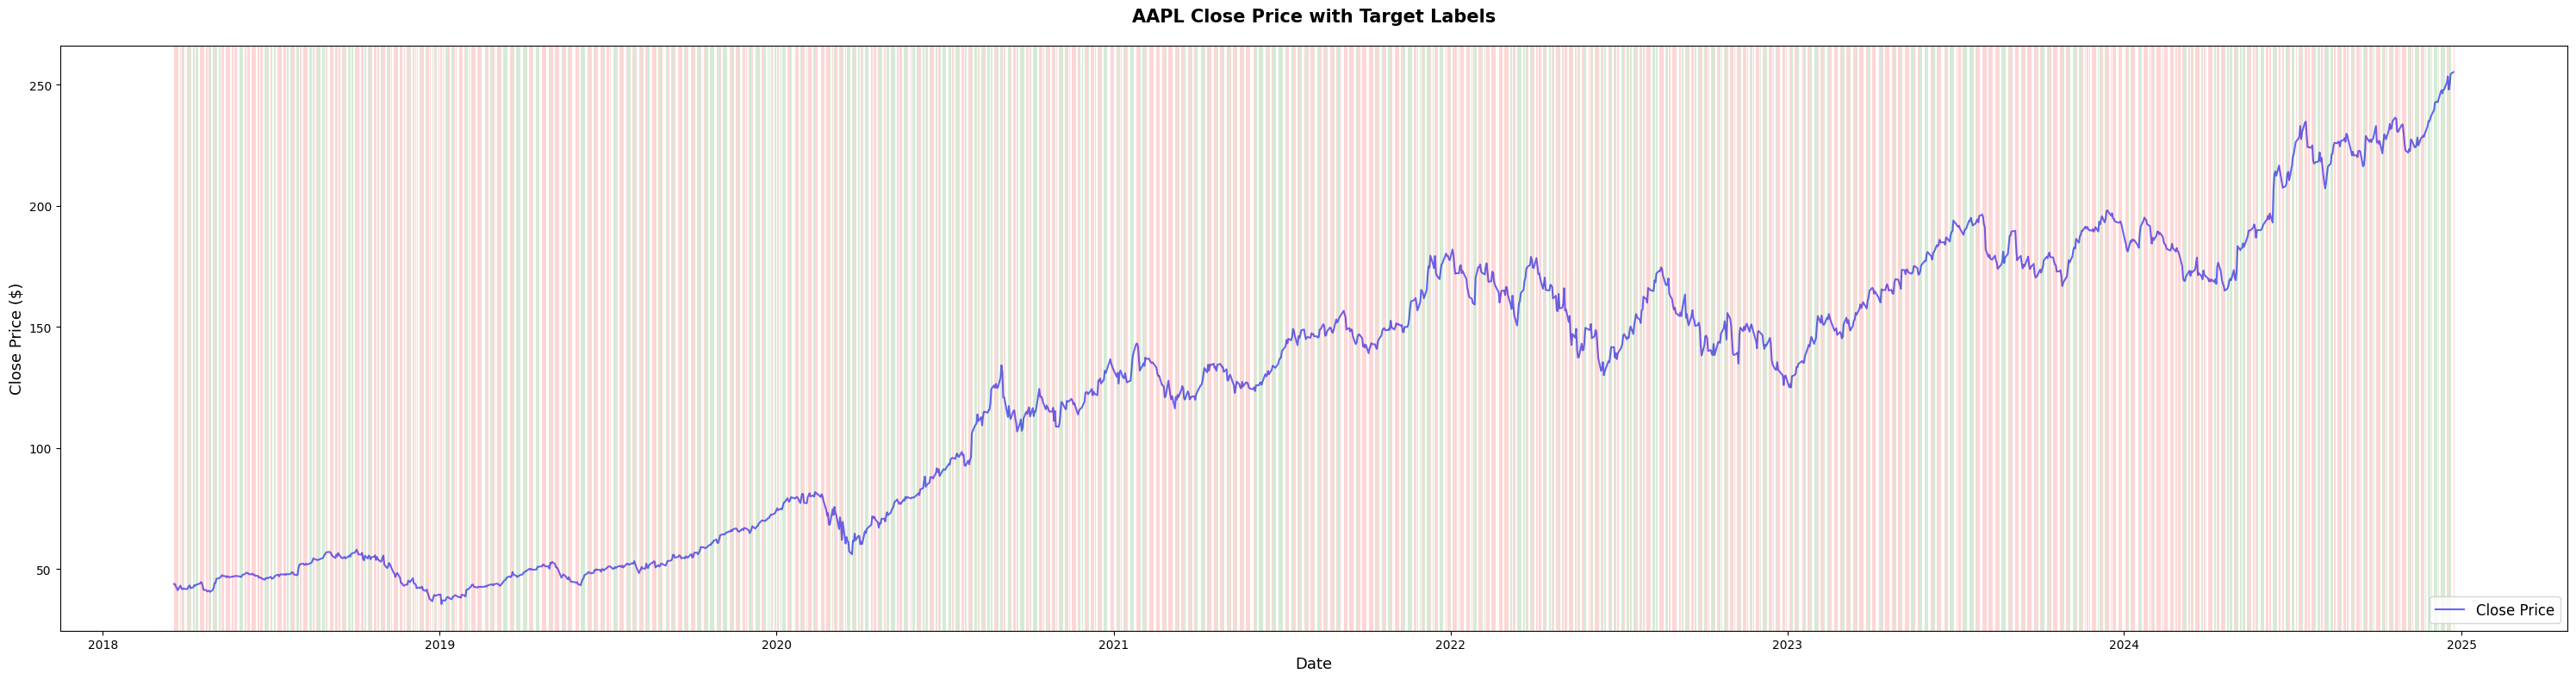

In [17]:
def calculate_target(df, window=5, profit_take_pct=2.0, stop_loss_pct=1.0):
    """
    Calcola le etichette binarie (0 o 1) basandosi sul metodo a due barriere.

    Args:
        df (pd.DataFrame): DataFrame con i dati di prezzo (deve contenere 'Close', 'High', 'Low').
        window (int): L'orizzonte temporale massimo in giorni per raggiungere una barriera.
        profit_take_pct (float): La soglia percentuale per la barriera di profitto.
        stop_loss_pct (float): La soglia percentuale per la barriera di stop-loss.

    Returns:
        pd.Series: Una serie di etichette (0, 1) o NaN se non ci sono dati futuri.
    """
    
    targets = []
    
    # Converti le percentuali in moltiplicatori
    profit_multiplier = 1 + (profit_take_pct / 100)
    stop_multiplier = 1 - (stop_loss_pct / 100)

    for i in range(len(df)):
        # Controlla se ci sono abbastanza dati futuri per la finestra
        if i + window >= len(df):
            targets.append(np.nan)
            continue

        start_price = df['Close'].iloc[i]
        
        # Calcola le barriere per questo specifico punto di partenza
        upper_barrier = start_price * profit_multiplier
        lower_barrier = start_price * stop_multiplier
        
        target_label = 0  # Default: consideriamo un timeout come una non-vittoria (0)
        
        # Ciclo sui giorni futuri per vedere quale barriera viene toccata prima
        for j in range(1, window + 1):
            future_high = df['High'].iloc[i + j]
            future_low = df['Low'].iloc[i + j]
            
            # 1. Controlla se la barriera di profitto è stata raggiunta
            if future_high >= upper_barrier:
                target_label = 1
                break  # Esci dal ciclo interno, abbiamo un vincitore!
            
            # 2. Controlla se la barriera di stop-loss è stata raggiunta
            if future_low <= lower_barrier:
                target_label = 0
                break  # Esci dal ciclo interno, abbiamo un perdente!
        
        # Se il ciclo finisce senza un 'break', l'etichetta rimane il default (0)
        targets.append(target_label)
        
    return pd.Series(targets, index=df.index)


# --- Come usarla nel tuo codice (sostituisci la parte di calcolo del target) ---

# Applica la nuova funzione
# Puoi facilmente sperimentare con diverse soglie e finestre


df['Target'] = calculate_target(df, window=5, profit_take_pct=2, stop_loss_pct=1.0)
df = df.dropna(subset=["Target"])
df['Target'] = df['Target'].astype(int) # Converte in intero

tag_counts = df["Target"].value_counts()
print(f"  Conteggio etichette:")
print(tag_counts.values)
print(f"  Totale righe: {len(df)}")
print("-" * 40)


# Plot close prices
plt.figure(figsize=(30, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.6, linewidth=1.5)

# Plot vertical lines for each day
for idx in df.index:
    if df.loc[idx, 'Target'] == 1:
        plt.axvline(x=idx, color='green', alpha=0.15, linewidth=0.8, linestyle='-')
    else:
        plt.axvline(x=idx, color='red', alpha=0.15, linewidth=0.8, linestyle='-')

# Add markers on top
#plt.scatter(ones.index, ones['Close'], marker='^', color='green', s=60, label='No Drop (1)', alpha=0.8, edgecolors='darkgreen', linewidths=1.5, zorder=5)
#plt.scatter(zeros.index, zeros['Close'], marker='v', color='red', s=60, label='Drop >= 1% (0)', alpha=0.8, edgecolors='darkred', linewidths=1.5, zorder=5)

plt.xlabel('Date', fontsize=13)
plt.ylabel('Close Price ($)', fontsize=13)
plt.title(f'{ticker} Close Price with Target Labels', 
          fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()


In [18]:
features = ["High","Volume","Return","MACD","MACD_Signal",
            "MACD_Hist","EMA20","Vol_EMA20",
            "RSI","Boll_Up","Boll_Down","Dist_low_band",
            "Dist_up_band","%K","%D","R_EMA20","ADX","+DI",
            "-DI","ATR","BB_pctB","ROC","OBV","CMF",
            "MACD_norm","RSI_diff","DI_diff","SMA_slope",
            "RSI_slope","MACD_slope","%K_slope","%D_slope",
            "ATR_slope","OBV_slope","ADX_slope","RSI_overbought",
            "RSI_oversold","Stoch_overbought","Stoch_oversold",
            "MACD_crossover_signal","Vol_pct_change","RSI_x_Vol_Change",
            "ATR_pct","RSI_SMA15","RSI_vs_SMA","MACD_Hist_Std20",
            "SP_Return","SP_RSI","SP_Dist_SMA"]


X = df[features]
y = df["Target"]


len(features)

49

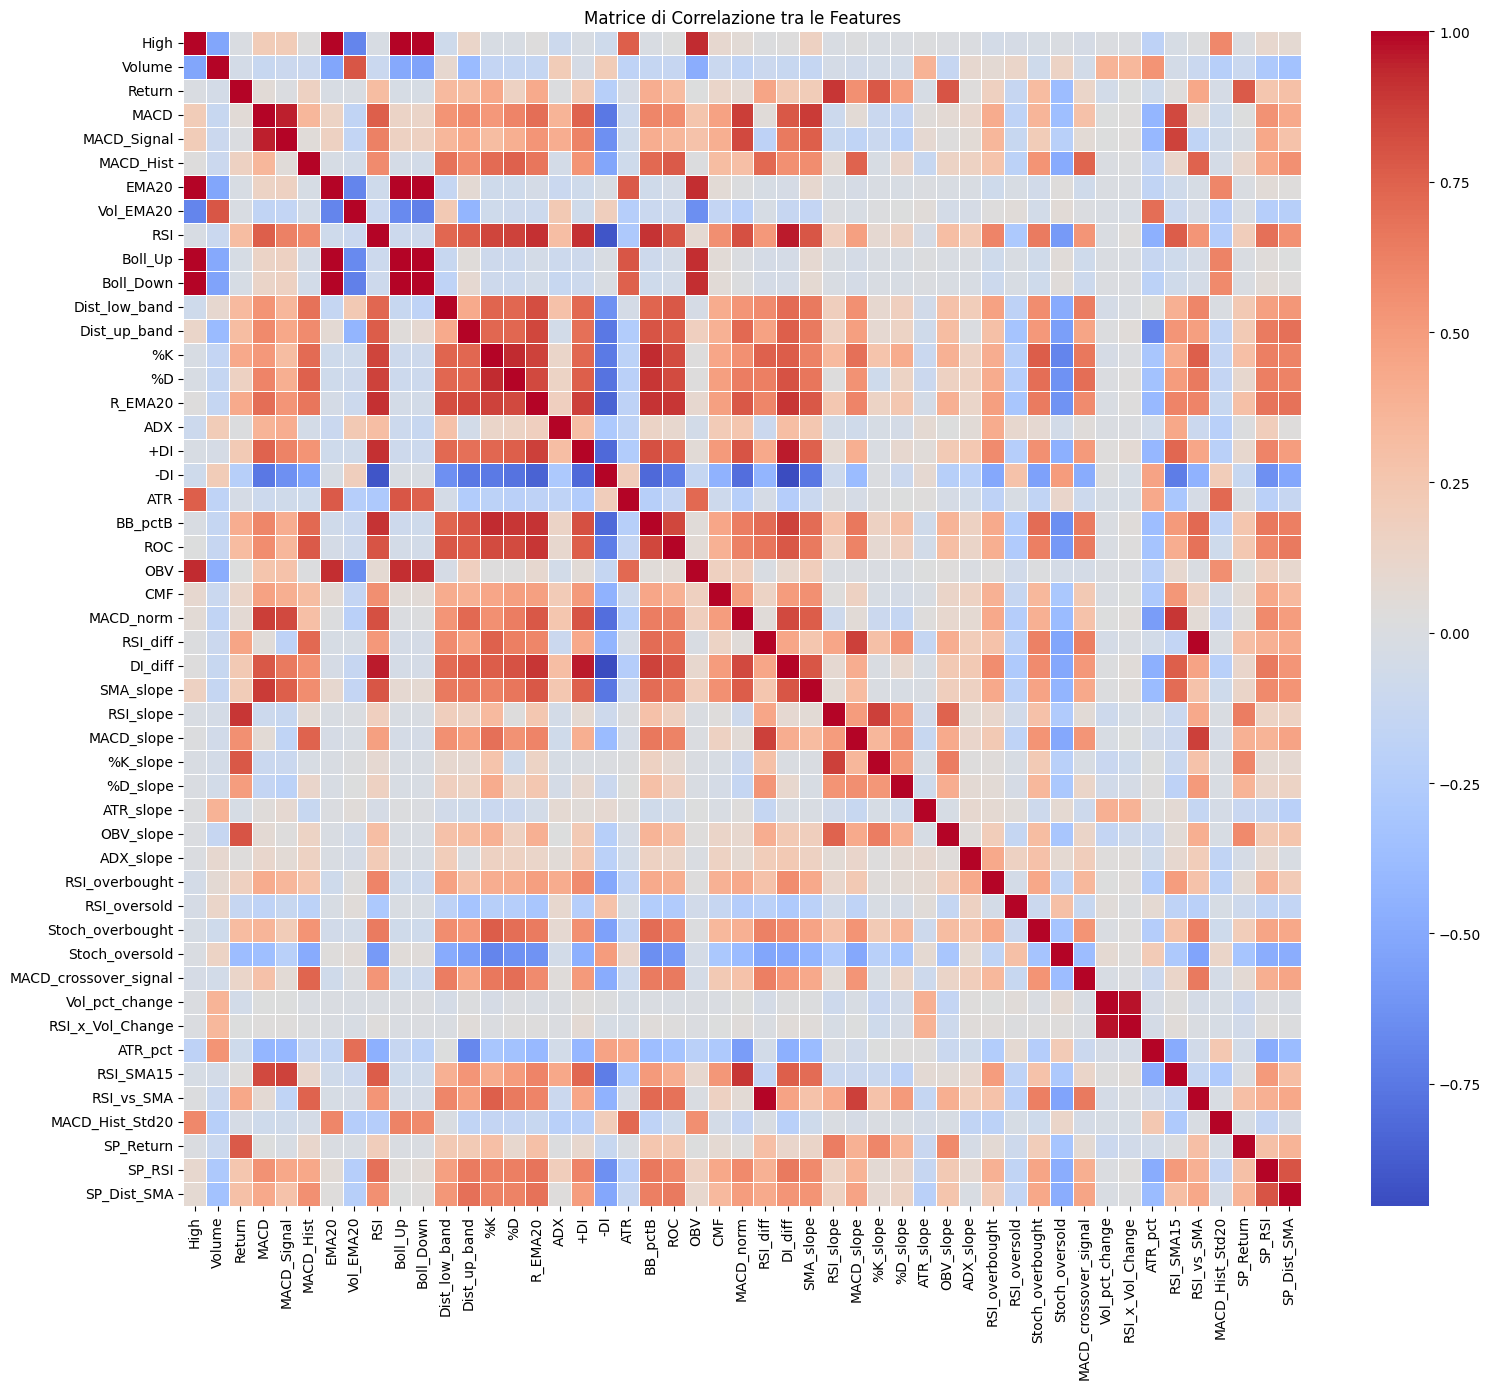


--- Coppie di Feature Altamente Correlate (> 0.9) ---
              Indice_A          Indice_B  Correlation
303              EMA20           Boll_Up     0.998436
447            Boll_Up             EMA20     0.998436
496          Boll_Down             EMA20     0.997861
304              EMA20         Boll_Down     0.997861
2181        RSI_vs_SMA          RSI_diff     0.997786
1269          RSI_diff        RSI_vs_SMA     0.997786
6                 High             EMA20     0.997022
294              EMA20              High     0.997022
9                 High           Boll_Up     0.995034
441            Boll_Up              High     0.995034
451            Boll_Up         Boll_Down     0.993609
499          Boll_Down           Boll_Up     0.993609
490          Boll_Down              High     0.993315
10                High         Boll_Down     0.993315
2001    Vol_pct_change  RSI_x_Vol_Change     0.975329
2049  RSI_x_Vol_Change    Vol_pct_change     0.975329
859                +DI     

In [19]:
correlation_matrix = df[features].corr()

plt.figure(figsize=(16, 14)) # Rendi la figura grande per leggibilità
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Matrice di Correlazione tra le Features")
plt.tight_layout()
plt.show()

# Potresti anche stampare le coppie più correlate
# Crea un DataFrame pulito della matrice di correlazione
corr_df = correlation_matrix.stack().reset_index()
corr_df.columns = ["Indice_A", "Indice_B", "Correlation"]
# Filtra per correlazioni alte (escludendo la correlazione di una feature con se stessa)
high_corr_pairs = corr_df[
    (corr_df["Correlation"].abs() > 0.9) & (corr_df["Indice_A"] != corr_df["Indice_B"])
]
print("\n--- Coppie di Feature Altamente Correlate (> 0.9) ---")
print(high_corr_pairs.sort_values(by="Correlation", ascending=False))


=== Mutual Information Score Ranking ===
                  Feature  MI_Score
9                 Boll_Up  0.033332
8                     RSI  0.029999
19                    ATR  0.024974
12           Dist_up_band  0.024195
22                    OBV  0.023715
0                    High  0.020390
15                R_EMA20  0.019649
16                    ADX  0.015944
30               %K_slope  0.015489
10              Boll_Down  0.015268
42                ATR_pct  0.014094
23                    CMF  0.012212
6                   EMA20  0.012079
44             RSI_vs_SMA  0.011411
34              ADX_slope  0.008769
13                     %K  0.008646
11          Dist_low_band  0.008254
47                 SP_RSI  0.007511
7               Vol_EMA20  0.007047
28              RSI_slope  0.006140
5               MACD_Hist  0.005391
26                DI_diff  0.005205
20                BB_pctB  0.005052
37       Stoch_overbought  0.004233
32              ATR_slope  0.004178
33              OBV_sl

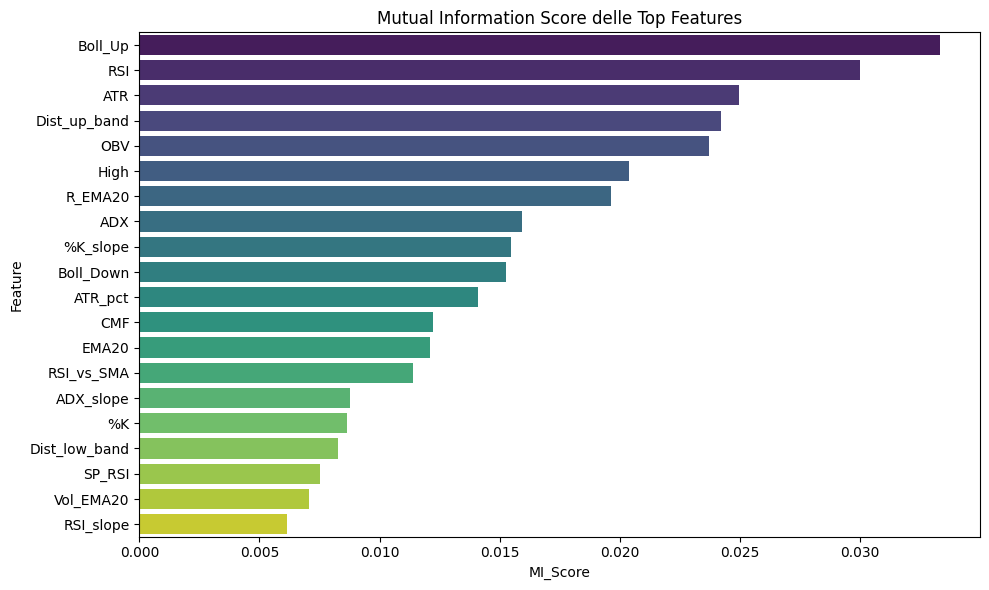

In [20]:
from sklearn.feature_selection import mutual_info_classif

# Mutual Information Score
# Misura la dipendenza tra due variabili. Un valore più alto significa maggiore dipendenza.
# Può catturare relazioni non lineari.

# C'è bisogno che y siano dei numeri. Usiamo y = df[y_label].astype("category").cat.codes  da prima

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    "Feature": features,
    "MI_Score": mi_scores
}).sort_values("MI_Score", ascending=False)

print("\n=== Mutual Information Score Ranking ===")
print(mi_df)

# Visualizzazione
plt.figure(figsize=(10, 6))
sns.barplot(x="MI_Score", y="Feature", data=mi_df.head(20), hue="Feature", palette="viridis", legend=False)
plt.title("Mutual Information Score delle Top Features")
plt.tight_layout()
plt.show()

In [21]:

# --- 1. NUOVA DIVISIONE CRONOLOGICA IN TRE SET ---
# 70% Train, 15% Validation, 15% Test
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print(f"Dimensioni set: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")

# Converti in DMatrix una sola volta
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val) # Il validation set per il tuning
dtest = xgb.DMatrix(X_test, label=y_test) # Il test set per la valutazione finale



Dimensioni set: Train=1192, Validation=255, Test=257


In [22]:
num_rounds = 1000
early_stop = 20

1.3326810176125246
Starting hyperparameter optimization with Optuna...


  0%|          | 0/100 [00:00<?, ?it/s]

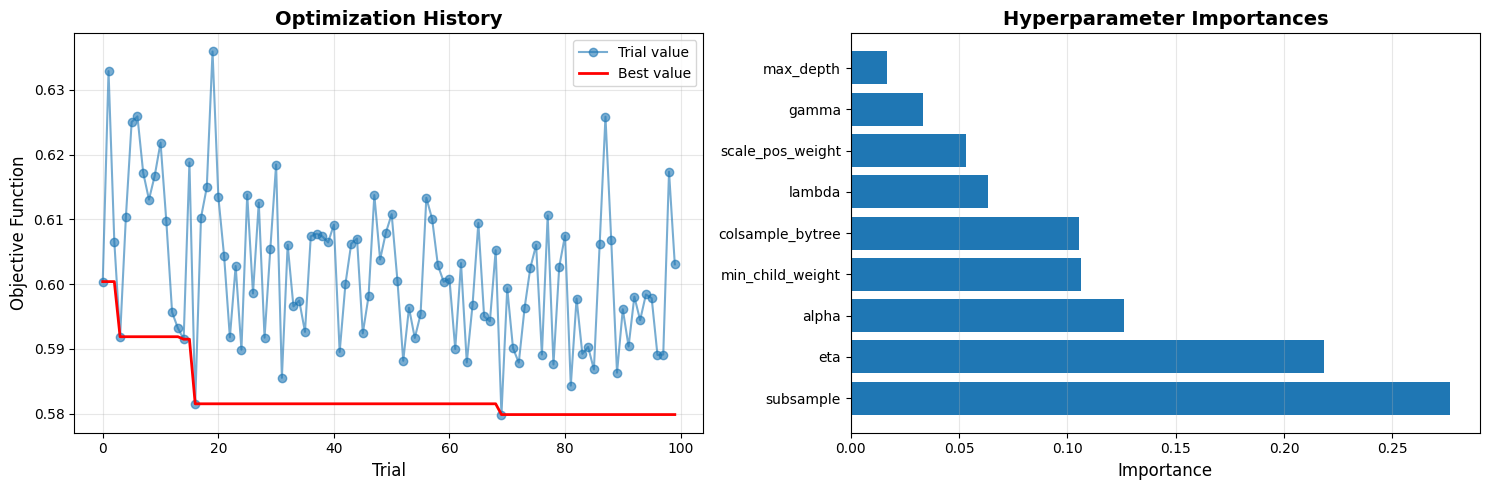

In [23]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- 2. TUNING CON OPTUNA (USANDO TRAIN E VALIDATION) ---
pos_weight = np.sum(y_train == 0) / max(np.sum(y_train == 1), 1)
print(pos_weight)

def objective(trial: optuna.trial.Trial) -> float:
    params_trial = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree', 
        'eta': trial.suggest_float('eta', 0.005, 0.05, log=True),
        
        # 2. FORCE ROBUSTNESS (Crucial for Finance)
        # Higher min_child_weight prevents the model from learning specific
        # price movements of specific days. It forces generalization.
        'min_child_weight': trial.suggest_int('min_child_weight', 20, 50),
        
        # 3. INCREASE DEPTH BUT LIMIT SPLITS
        # Allow deeper trees to find complex patterns, but use Gamma to prune them hard.
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'gamma': trial.suggest_float('gamma', 1.0, 10.0), # Very high gamma acts as a conservative gatekeeper
        
        # 4. REGULARIZATION
        'lambda': trial.suggest_float('lambda', 1.0, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1.0, 10.0, log=True),
        
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.999 * pos_weight, 1.001 * pos_weight),
        
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'random_state': 42,
    }


    # NOTA: Ora usiamo dval (il validation set) per la valutazione nel tuning
    model = xgb.train(
        params=params_trial,
        dtrain=dtrain,
        num_boost_round=num_rounds,
        evals=[(dval, 'validation')],
        early_stopping_rounds=early_stop,
        verbose_eval=False
    )
    
    # Previsioni sul validation set
    preds_proba = model.predict(dval, iteration_range=(0, model.best_iteration))
    
    metric_score = average_precision_score(y_val, preds_proba)

    # We want to MAXIMIZE precision/score, so we minimize the negative or inverse
    return float(1.0 - metric_score)

print("Starting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='minimize', study_name='xgboost_tuning')
study.optimize(objective, n_trials=100, show_progress_bar=True)

best_params = study.best_params

# Visualize optimization history with matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot optimization history
trials = study.trials
trial_numbers = [t.number for t in trials]
trial_values = [t.value for t in trials]

# Handle possible None values returned by incomplete/failed trials:
# - use +inf for min computation so None values don't interfere
# - use np.nan for plotting so matplotlib will skip them
numeric_for_min = [v if v is not None else float('inf') for v in trial_values]
plot_values = [v if v is not None else np.nan for v in trial_values]

best_values = [min(numeric_for_min[:i+1]) for i in range(len(numeric_for_min))]

ax1.plot(trial_numbers, plot_values, 'o-', alpha=0.6, label='Trial value')
ax1.plot(trial_numbers, best_values, 'r-', linewidth=2, label='Best value')
ax1.set_xlabel('Trial', fontsize=12)
ax1.set_ylabel('Objective Function', fontsize=12)
ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot parameter importances
importances = optuna.importance.get_param_importances(study)
params_names = list(importances.keys())
params_values = list(importances.values())

ax2.barh(params_names, params_values)
ax2.set_xlabel('Importance', fontsize=12)
ax2.set_title('Hyperparameter Importances', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


Param = {
    'eta': 0.04984489274413382,
    'min_child_weight': 40,
    'max_depth': 8,
    'gamma': 4.98408516196549,
    'lambda': 3.2242761979887344,
    'alpha': 2.6650255070526185,
    'scale_pos_weight': 1.3331912435911248,
    'subsample': 0.7337069806615447,
    'colsample_bytree': 0.8190744120274299,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
}


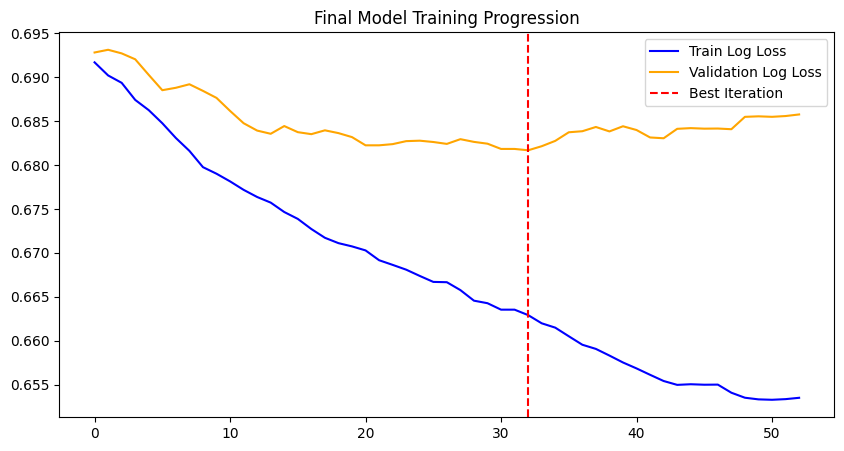


--- 3. Tuning Dynamic Threshold (K-Factor) on Validation ---
Optimization Complete.
Best K-Factor: 0.7
Best Validation MCC: -0.0419

--- 4. Final Evaluation on TEST SET ---

Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.35      0.25      0.30       102
           0       0.58      0.69      0.63       155

    accuracy                           0.52       257
   macro avg       0.47      0.47      0.46       257
weighted avg       0.49      0.52      0.50       257

Matthews Corr Coef: -0.0592
Log Loss: 0.6812
Total Trades: 74 out of 257 days


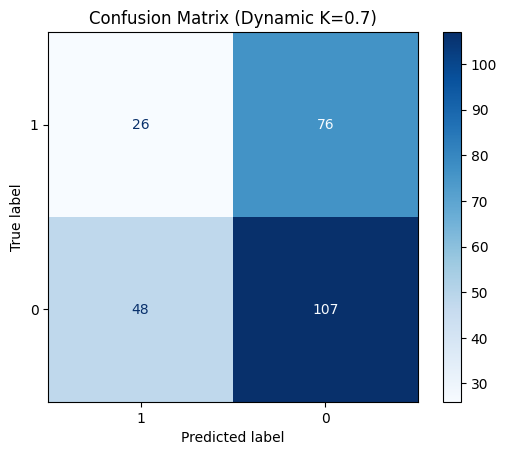

In [24]:
final_params = study.best_params
final_params['objective'] = 'binary:logistic'
final_params['eval_metric'] = 'logloss'
final_params['booster'] = 'gbtree'

evals_result = {} 
print("Param = {")
for k, v in final_params.items():
    print(f"    '{k}': {repr(v)},")
print("}")

model = xgb.train(
    params=final_params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    evals_result=evals_result,
    early_stopping_rounds=early_stop,
    verbose_eval=False
)

# --- PLOT LEARNING CURVE ---
train_logloss = evals_result['train']['logloss']
val_logloss = evals_result['validation']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_logloss, label='Train Log Loss', color='blue')
plt.plot(val_logloss, label='Validation Log Loss', color='orange')
plt.axvline(x=model.best_iteration, color='red', linestyle='--', label='Best Iteration')
plt.title('Final Model Training Progression')
plt.legend()
plt.show()

# ==========================================
# 3. DYNAMIC THRESHOLD TUNING (Finding 'K')
# ==========================================
print("\n--- 3. Tuning Dynamic Threshold (K-Factor) on Validation ---")

# Get raw probabilities on Validation
val_probs = model.predict(dval, iteration_range=(0, model.best_iteration))
val_series = pd.Series(val_probs).astype(float)

# Settings
window_size = 40
best_mcc = -1
best_precision = 0
best_k = 1.5  # Default start

# Loop to find the best K (Standard Deviation Multiplier)
for k in np.arange(0.5, 2.0, 0.1):
    # 1. Calculate Rolling Stats
    roll_mean = val_series.rolling(window=window_size).mean()
    roll_std = val_series.rolling(window=window_size).std()
    
    # 2. Calculate Threshold Curve
    # Ensure k is a plain Python float and use Series.mul for safe broadcasting
    dynamic_thresh = roll_mean + roll_std.mul(float(k))
    
    # 3. Generate Predictions
    # We treat the first 'window_size' days as 0 (no signal) because they are NaN
    preds = (val_series > dynamic_thresh).fillna(False).astype(int)
    
    # 4. Evaluate
    # Check if we actually made trades (avoid K being so high we trade 0 times)
    if preds.sum() < 5: continue 
    
    mcc = matthews_corrcoef(y_val, preds)
    if mcc > best_mcc:
        best_mcc = mcc
        best_k = k

    #precision = precision_score(y_val, preds)
    #if precision > best_precision:
    #    best_precision = precision
    #    best_k = k

print(f"Optimization Complete.")
print(f"Best K-Factor: {best_k:.1f}")
print(f"Best Validation MCC: {best_mcc:.4f}")

# ==========================================
# 4. FINAL EVALUATION (On Test Set)
# ==========================================
print("\n--- 4. Final Evaluation on TEST SET ---")

# Get raw probabilities on Test
test_probs = model.predict(dtest, iteration_range=(0, model.best_iteration))
test_series = pd.Series(test_probs)

# --- WARM START TRICK ---
# To calculate the rolling stats for the FIRST day of the Test set,
# we need the LAST 30 days of the Validation set.
combined_series = pd.concat([val_series.iloc[-window_size:], test_series]).reset_index(drop=True)

# Calculate rolling stats on the COMBINED data
roll_mean_test = combined_series.rolling(window=window_size).mean()
roll_std_test = combined_series.rolling(window=window_size).std()

# Apply the formula using the BEST K we found earlier
dynamic_thresh_test = roll_mean_test + roll_std_test.mul(float(best_k))

# Slice back to get ONLY the Test portion
# Remove the 'warm up' data we added
dynamic_thresh_test = dynamic_thresh_test.iloc[window_size:].reset_index(drop=True)

# Generate Final Predictions
y_pred_test = (test_series > dynamic_thresh_test).astype(int)

# --- METRICS ---
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, labels=[1, 0]))

print(f"Matthews Corr Coef: {matthews_corrcoef(y_test, y_pred_test):.4f}")
print(f"Log Loss: {log_loss(y_test, test_probs):.4f}")
print(f"Total Trades: {y_pred_test.sum()} out of {len(y_pred_test)} days")

# --- VISUALIZATION 1: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_test, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (Dynamic K={best_k:.1f})")
plt.show()

In [25]:
import os
import joblib

os.makedirs("models", exist_ok=True)

artifact = {
    "model": model,
    "features": X_train.columns.tolist() if hasattr(X_train, "columns") else None,
    "aggresive" : best_k
}

out_path = f"models/{ticker}.joblib"
joblib.dump(artifact, out_path)


['models/AAPL.joblib']